# Required Libraries

In [1]:
# For analysis and visulaisation
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
import re
import itertools    
import wordcloud

# Muting warnings
import warnings
warnings.filterwarnings('ignore')


# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

# For building our Models
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Conv1D,Bidirectional,SpatialDropout1D,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, cross_validate



# For creating vocabulary dictionary
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For model evaluation
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.metrics import confusion_matrix,classification_report, log_loss, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, DetCurveDisplay, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# For processing texts
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Loading data

In [2]:
# Loading data with pandas 
data = pd.read_csv('dataset.csv')

In [3]:
# Retrieving top 5 records in the dataset
data.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


# Data Exploraton

# Mising Values

In [4]:
# Defining function for missing values 
def missing_value_of_data(df):
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [5]:
# Applying missing values function 
missing_value_of_data(data)

,Total,Percentage
text,0,0.0
humor,0,0.0


# Count Values

In [6]:
# Function for counting label values 
def count_values_in_column(df,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [7]:
# Applying value count function 
count_values_in_column(data,'humor')

,Total,Percentage
False,100000,50.0
True,100000,50.0


<Axes: xlabel='count', ylabel='humor'>

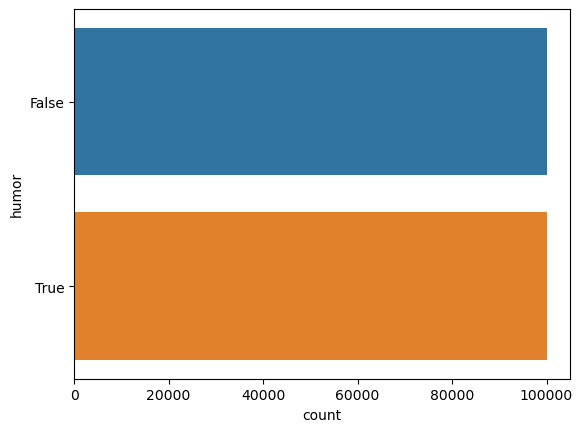

In [29]:
# A histogram showing label class distribution
sns.countplot(data, y="humor")

# Unique Values

In [9]:
# Defining unique values function 
def unique_values_in_column(df,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

In [10]:
# Applying unique values function 
unique_values_in_column(data,'humor')

,Unique Values
0,False
1,True


# Duplicate Values

In [11]:
# Defining function to check duplicates
def duplicated_values_data(df):
    duplicate=[]
    columns=data.columns
    for i in data.columns:
        duplicate.append(sum(data[i].duplicated()))
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis=1,keys=['Columns','Duplicate count'])

In [12]:
# Applying duplicate function 
duplicated_values_data(data)

,Columns,Duplicate count
0,text,0
1,humor,199998


# Stat

In [13]:
# Retrieving summary statistics for data
data.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


# Cleaning texts

In [15]:
# Installing module for contracted words 
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Installing NLTK for text processing 
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\talkt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
nltk.download ('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\talkt\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Removing contracted forms
import contractions

data["text"] = data["text"].apply(lambda x: contractions.fix(x))

__The code in the cell below was extracted from : https://www.kaggle.com/code/anuarrr/nlp-humor-detection-mnb-xgb-bert It is setup to remove or correct certain objects in the texts__

In [20]:
import re
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_punct(text):
    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)

def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  {
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",
                            "gawx": "georgia weather",
                            "scwx": "south carolina weather",
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }


        # Some common abbreviations
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk",
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart",
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet",
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously",
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }

        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')

        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)

        return text

In [21]:
# Applying the cleaining functions defined above
data["text"] = data["text"].apply(lambda x: remove_URL(x))
data["text"] = data["text"].apply(lambda x: remove_html(x))
data["text"] = data["text"].apply(lambda x: remove_non_ascii(x))
data["text"] = data["text"].apply(lambda x: remove_punct(x))
data["text"] = data["text"].apply(lambda x: other_clean(x))

# Stopwords removal

In [22]:
# Removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['removed_stopwords'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatization

In [23]:
# Defining and applying the lemmatization function to lemmatize texts
def lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

data['lemmatized_texts'] = lemmatized_text(data['removed_stopwords'])

In [35]:
# Retrieving top 5 rows to view all the changes applied in the dataset.
data.head()

,text,humor,removed_stopwords,lemmatized_texts
0,Joe biden rules out 2020 bid guys i am not run...,False,Joe biden rules 2020 bid guys running,Joe biden rule 2020 bid guy running
1,Watch darvish gave hitter whiplash with slow p...,False,Watch darvish gave hitter whiplash slow pitch,Watch darvish gave hitter whiplash slow pitch
2,What do you call a turtle without its she will...,True,What call turtle without dead,What call turtle without dead
3,5 reasons the 2016 election feels so personal,False,5 reasons 2016 election feels personal,5 reason 2016 election feel personal
4,Pasco police shot mexican migrant from behind ...,False,Pasco police shot mexican migrant behind new a...,Pasco police shot mexican migrant behind new a...


# Visualising Text Contents

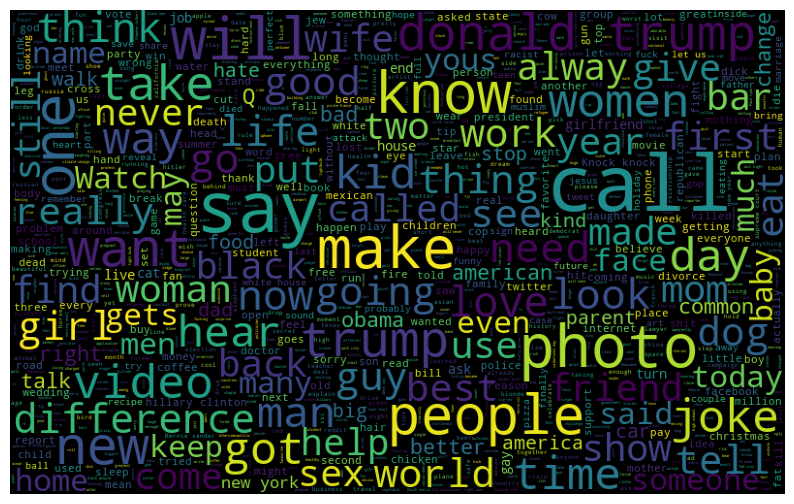

In [25]:
# Wordcloud visualises words in the texts base on frequencey 
wc = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS,max_font_size=80, max_words=5000, width = 800, height = 500,background_color='black').generate(' '.join(txt for txt in data["text"]))
fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(wc, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wc)

# Plotting top 10 words

In [31]:
# How many unique words in the vocabulary?
def frequency_dict(words):
    all_words = " ".join([str(sentence) for sentence in data['lemmatized_texts']]).split()
    freq_dict = {}
    for word in all_words:
        freq_dict.setdefault(word, 0) # set the default value to 0
        freq_dict[word] += 1  # increment the value by 1
    voc_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))
    return voc_freq_dict
voc_freq_dict=frequency_dict(data)

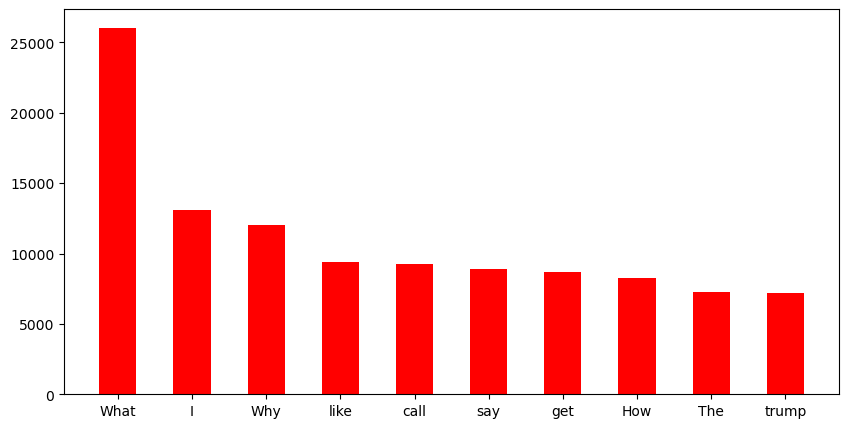

In [36]:
plt.figure(figsize=(10, 5))
hist_plot = dict(itertools.islice(voc_freq_dict.items(), 10))
plt.bar(hist_plot.keys(), hist_plot.values(), width=0.5, color='red')
plt.xticks(rotation=360)
plt.show()

# Splitting data into train and test

In [134]:
# Splitting data into train and test groups
x_train, x_test, y_train, y_test= train_test_split(data["lemmatized_texts"], data["humor"], test_size=0.2, random_state=7)

# Tokenisation with Keras

In [135]:
MAX_NB_WORDS = 10000 # Initializing the maximum number of words to consider as features for tokenizer
MAX_SEQUENCE_LENGTH = 30 # Initalizing maximum sequence length
tokenizer =Tokenizer(lower = False)      # Creating the Tokenizer Object

class Tokenization():

    def __init__(self, x_train, x_test, tokenizer):
        self.x_train=x_train
        self.x_test=x_test
        self.tokenizer=tokenizer


    def padding_sequence(self):
        self.tokenizer.fit_on_texts(self.x_train)     # Whole text is passed into the object
        x_train =pad_sequences(self.tokenizer.texts_to_sequences(self.x_train),maxlen = MAX_SEQUENCE_LENGTH) # padding sequence within the maximum length 
        x_test =pad_sequences(self.tokenizer.texts_to_sequences(self.x_test),maxlen = MAX_SEQUENCE_LENGTH)
        word_index =self.tokenizer.word_index  # Tries to create a dictionary of vocabulary
        vocab_size = len(self.tokenizer.word_index) + 1 # Total unique words in our data

        return x_train, x_test, word_index, vocab_size

x_train, x_test, word_index, vocab_size = Tokenization(x_train, x_test, tokenizer).padding_sequence()

# Encoding Target Variable

In [136]:
# Encoding and reshaping the target variables
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# GloVe Embedding

__The code in the cell below was adopted from the link: https://www.kaggle.com/code/francoisdubois/build-a-word-embedding-with-glove-matrix__

In [137]:
# Creating an embedding matrix by importing and applying the GoVe algorithm
embeddings_index = {}
embedding_dim=100
def get_embedding_matrix(word_index,vocab_size):
    with open('glove.6B.100d.txt', encoding="utf8") as file:
        for line in file:
            values = line.split()
            word = value = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
        file.close()

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [138]:
# Applying the embedding functon created for GloVe
embedding_matrix = get_embedding_matrix(word_index, vocab_size)

# Base model for SVM 

Training accuracy:  0.4369
              precision    recall  f1-score   support

           0       0.40      0.25      0.31     20002
           1       0.45      0.62      0.52     19998

    accuracy                           0.44     40000
   macro avg       0.43      0.44      0.42     40000
weighted avg       0.43      0.44      0.42     40000



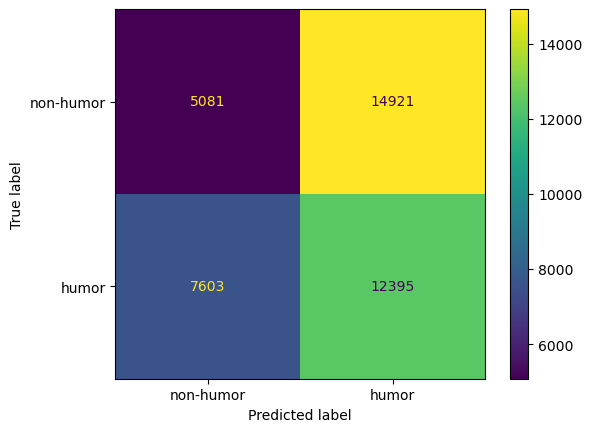

In [139]:
model = LinearSVC() # Instatiating the linearSVM

# Defining function that trains and evaluate the svm base model using classification report and confusion matrix 
def Base_Model_SVM(mod):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("Training accuracy: ", accuracy_score(y_test, y_pred))

    print(classification_report(y_test, y_pred)) 

    target_names = ['non-humor', 'humor']
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp.plot()
    plt.show()
Base_Model_SVM(model)

# SVM Cross Validation and Hyperparameter Tuning 

In [103]:
# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'penalty': ['l1', 'l2']} 
 
 
# instantiating an object of GridSearchCV for tunning
grid = GridSearchCV(LinearSVC(),param_grid=param_grid, scoring='accuracy', cv=4,n_jobs=-1, verbose=3)

# Fitting the model for grid search
model_grid = grid.fit(x_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [104]:
# Print best parameter after tuning
print(model_grid.best_params_)

{'C': 1, 'penalty': 'l2'}


              precision    recall  f1-score   support

           0       0.57      0.39      0.46     20002
           1       0.54      0.70      0.61     19998

    accuracy                           0.55     40000
   macro avg       0.55      0.55      0.54     40000
weighted avg       0.55      0.55      0.54     40000



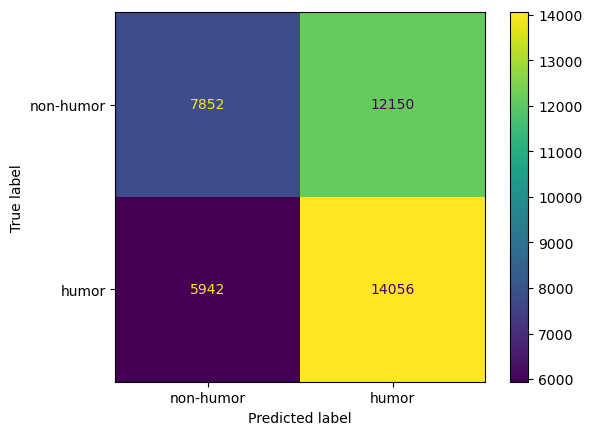

In [106]:
# Evaluating the gridsearch model with classification report and confusion matrix 
y_pred =model_grid.predict(x_test)
print(classification_report(y_test, y_pred)) 

target_names = ['non-humor', 'humor']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot()
plt.show()

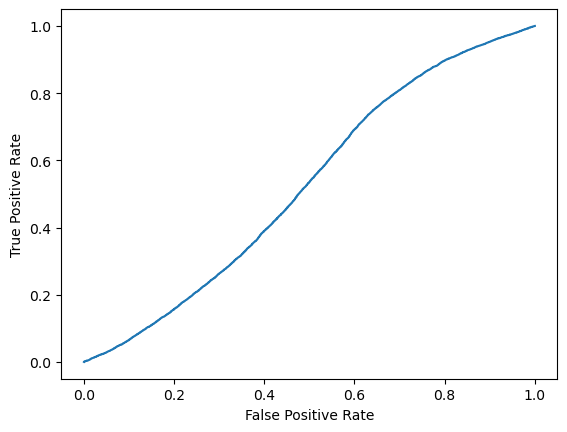

In [107]:
# Evaluating gridsearch model with roc curve
y_score = model_grid.decision_function(x_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Base M LSTM 

In [38]:
# Defining a function for the base LSTM model

def RNN_LSTM(vocab,embed_dim,embed_matrix, max_seq_len):
    # Creating an Embedding Layer
    embedding_layer = Embedding(vocab_size,embedding_dim,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)

    # Creating the Layers
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs) # Model Object with input and output layers

    # Using the standard Adam as the optimiser
    model.compile(optimizer=Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

lstm_model=RNN_LSTM(vocab_size,embedding_dim,embedding_matrix,MAX_SEQUENCE_LENGTH)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           6776000   
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 100)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            32064     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048 

In [39]:
# Training and evaluating the base lstm model using accuracy and loss 
history = lstm_model.fit(x_train,y_train,batch_size=100,validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
1600/1600 [==============================] - 222s 136ms/step - loss: 0.3960 - accuracy: 0.8239 - val_loss: 0.3374 - val_accuracy: 0.8518
Epoch 2/5
1600/1600 [==============================] - 135s 85ms/step - loss: 0.3611 - accuracy: 0.8424 - val_loss: 0.3258 - val_accuracy: 0.8566
Epoch 3/5
1600/1600 [==============================] - 147s 92ms/step - loss: 0.3500 - accuracy: 0.8468 - val_loss: 0.3376 - val_accuracy: 0.8613
Epoch 4/5
1600/1600 [==============================] - 217s 136ms/step - loss: 0.3444 - accuracy: 0.8515 - val_loss: 0.3244 - val_accuracy: 0.8591
Epoch 5/5
1600/1600 [==============================] - 181s 113ms/step - loss: 0.3420 - accuracy: 0.8505 - val_loss: 0.3289 - val_accuracy: 0.8591


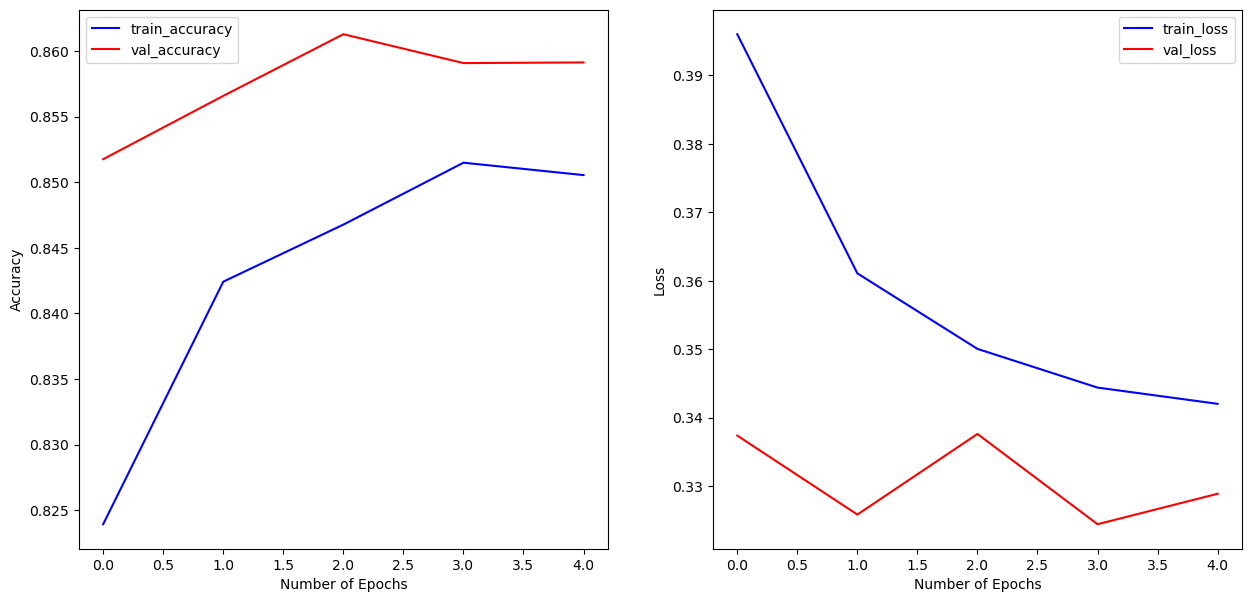

In [40]:
# Evaluating the base lstm model using accuracy and loss curves 
fig,ax=plt.subplots(1,2,figsize=(15,7))
ax[0].plot(history.history['accuracy'],c= 'b',label="train_accuracy")
ax[0].plot(history.history['val_accuracy'],c= 'r',label="val_accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(history.history['loss'],c= 'b',label="train_loss")
ax[1].plot(history.history['val_loss'],c= 'r',label="val_loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

In [42]:
# Evaluating the base lstm model using classification report 
y_pred=lstm_model.predict(x_test, batch_size=100, verbose=0)
report = classification_report(y_test, y_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     20002
           1       0.83      0.90      0.87     19998

    accuracy                           0.86     40000
   macro avg       0.86      0.86      0.86     40000
weighted avg       0.86      0.86      0.86     40000



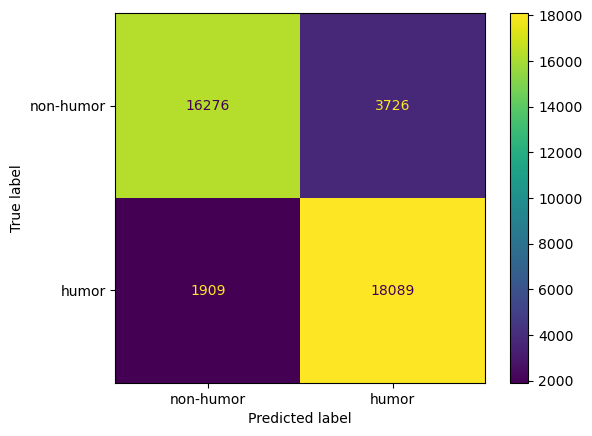

In [43]:
# Evaluating the base lstm model using confusion matrix 
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot()
plt.show()

# LSTM (With Cross Validation)

In [70]:
# Defining a function for the LSTM model for cross validation

def RNN_LSTM(vocab,embed_dim,embed_matrix, max_seq_len):
    # Creating an Embedding Layer
    embedding_layer = Embedding(vocab_size,embedding_dim,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)

    # Creating the Layers
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs) # Model Object with input and output layers

    # Using the standard Adam as the optimiser
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

lstm_model=RNN_LSTM(vocab_size,embedding_dim,embedding_matrix,MAX_SEQUENCE_LENGTH)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 30, 100)           6776000   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 30, 100)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 64)            32064     
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 512)               6604

In [71]:
# Performing cross validation and evaluating model
cv = KFold(n_splits=5, shuffle=True)
for train, test in cv.split(x_train, y_train): 
    global history 
    history = lstm_model.fit(x_train[train], y_train[train], batch_size=200, epochs=10, validation_data=(x_test, y_test))
    break

Epoch 1/10
640/640 [==============================] - 139s 210ms/step - loss: 0.4081 - accuracy: 0.8128 - val_loss: 0.3433 - val_accuracy: 0.8542
Epoch 2/10
640/640 [==============================] - 136s 212ms/step - loss: 0.3454 - accuracy: 0.8483 - val_loss: 0.3107 - val_accuracy: 0.8661
Epoch 3/10
640/640 [==============================] - 128s 200ms/step - loss: 0.3220 - accuracy: 0.8599 - val_loss: 0.2967 - val_accuracy: 0.8745
Epoch 4/10
640/640 [==============================] - 132s 207ms/step - loss: 0.3049 - accuracy: 0.8685 - val_loss: 0.2956 - val_accuracy: 0.8739
Epoch 5/10
640/640 [==============================] - 127s 199ms/step - loss: 0.2943 - accuracy: 0.8721 - val_loss: 0.2965 - val_accuracy: 0.8724
Epoch 6/10
640/640 [==============================] - 136s 213ms/step - loss: 0.2869 - accuracy: 0.8774 - val_loss: 0.2789 - val_accuracy: 0.8805
Epoch 7/10
640/640 [==============================] - 130s 203ms/step - loss: 0.2770 - accuracy: 0.8806 - val_loss: 0.2774 -

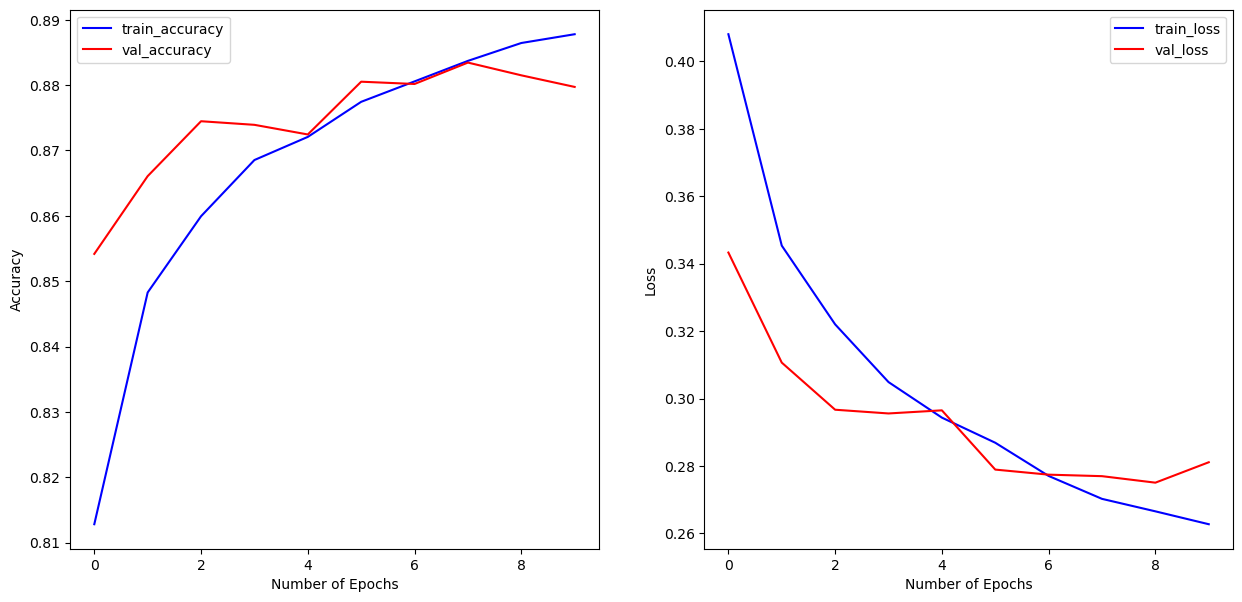

In [72]:
# Evaluating the cross validated lstm model using accuracy and loss curves 
fig,ax=plt.subplots(1,2,figsize=(15,7))
ax[0].plot(history.history['accuracy'],c= 'b',label="train_accuracy")
ax[0].plot(history.history['val_accuracy'],c= 'r',label="val_accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(history.history['loss'],c= 'b',label="train_loss")
ax[1].plot(history.history['val_loss'],c= 'r',label="val_loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

In [74]:
# Evaluating the cross validated lstm model with classification report 
y_pred=lstm_model.predict(x_test, batch_size=100, verbose=0)
report = classification_report(y_test, y_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.91      0.85      0.88     20002
           1       0.86      0.91      0.88     19998

    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88     40000



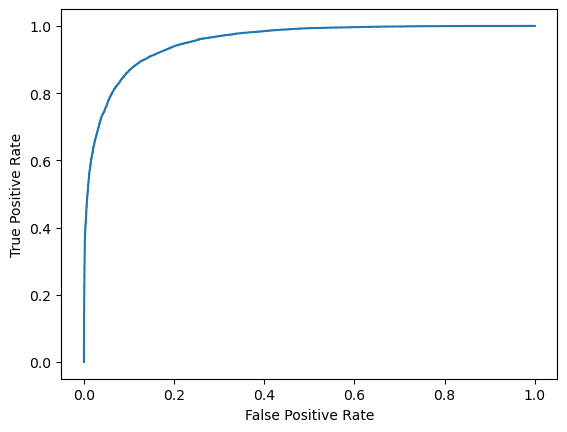

In [75]:
# Evaluating the cross validated lstm model with roc curve 
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

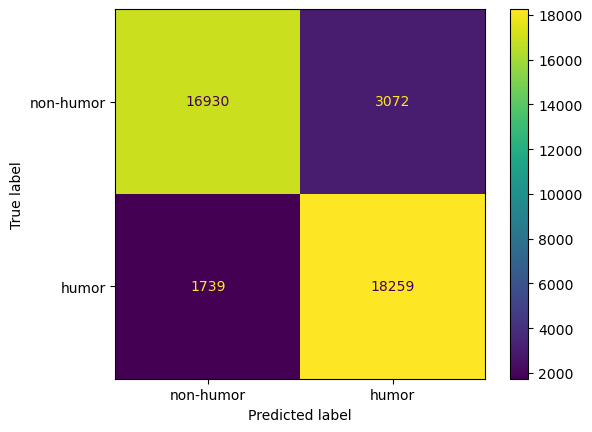

In [76]:
# Evaluating the cross validated lstm model with confusion matrix
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot()
plt.show()